# A dust model

In this tutorial we will simulate particles of dust that graviationally settle.
2D maps of dust deposition are available from within the AIBECS.
To use these, we will convert them into sources in the top layer of the model grid.
Once "born", depending on the settling velocity, these dust particles can spread horizontally until they eventually reach the sea floor and are buried in the sediments.

The governing equation of the 3D concentration field of dust, denoted $x_\mathsf{dust}$, is:

$$\left[\frac{\partial}{\partial t} + \nabla \cdot (\boldsymbol{u} + \boldsymbol{w} + \mathbf{K}\nabla)\right] x_\mathsf{dust} = s_\mathsf{dust}$$

where $\nabla \cdot \left[ \boldsymbol{u} - \mathbf{K} \nabla \right]$ and $\nabla \cdot \boldsymbol{w}$ represent the ocean circulation transport and the vertical settling of dust particles, respectively.
(Tracer transport operators are described in the documentation.)
The only source term, $s_\mathsf{dust}$, is the dust deposition.

In AIBECS, we must recast this equation in the generic form

$$\left[\frac{\partial}{\partial t} + \mathbf{T}(\boldsymbol{p})\right] \boldsymbol{x} = \boldsymbol{G}(\boldsymbol{x},\boldsymbol{p}).$$

We start by telling Julia we want to use the AIBECS and the OCIM0.1 transport matrix for the ocean circulation.

In [1]:
using AIBECS
grd, T_OCIM = OCIM0.load()

┌ Warning: Over-writing registration of the datadep
│   name = AIBECS-OCIM0.1
└ @ DataDeps /Users/runner/.julia/packages/DataDeps/gbyoa/src/registration.jl:15
┌ Info: You are about to use the OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, doi:10.1175/JPO-D-10-05011.1
│ 
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "DeVries_Primeau_2011" and "Primeau_etal_2013" keys.)
└ @ AIBECS.OCIM0 /Users/runner/work/AIBECS.jl/AIBECS.jl/src/OCIM0.jl:67


(, 
  [1     ,      1]  =  3.43554e-7
  [2     ,      1]  =  6.15762e-8
  [57    ,      1]  =  -2.61541e-7
  [10172 ,      1]  =  -7.12375e-7
  [10229 ,      1]  =  5.46158e-7
  [1     ,      2]  =  -1.09408e-7
  [2     ,      2]  =  3.1285e-7
  [3     ,      2]  =  1.98074e-9
  [58    ,      2]  =  -2.42077e-8
  ⋮
  [191168, 191167]  =  -1.81561e-7
  [190655, 191168]  =  -2.32625e-8
  [191165, 191168]  =  -1.08131e-7
  [191167, 191168]  =  1.42112e-7
  [191168, 191168]  =  6.11855e-8
  [191169, 191168]  =  -7.25416e-8
  [190656, 191169]  =  -1.80874e-9
  [191166, 191169]  =  -7.12552e-8
  [191168, 191169]  =  3.23538e-8
  [191169, 191169]  =  4.07233e-8)

The transport of dust is the sum of the ocean circulation and a settling-transport:

In [2]:
function T_dust(p)
    @unpack fsedremin = p
    return T_OCIM + transportoperator(grd, z -> w(z,p), fsedremin=fsedremin)
end

T_dust (generic function with 1 method)

For the settling transport of dust particles, we have used the `transportoperator` function
for which we need to define the settling velocity `w(z,p)` as a function of depth `z` and of the parameters `p`.

> *Note*:
> We have imposed a `fsedremin` remineralization at the sediment with its keyword argument.
> (Default is `fsedremin=1.0`.)
> This turns the settling transport into a sink that removes all the dust reaching the sea floor.

Following the assumption that $w(z) = w_0 + w' z$ increases linearly with depth, we write it as

In [3]:
function w(z,p)
    @unpack w₀, w′ = p
    return @. w₀ + w′ * z
end
z = depthvec(grd)

191169-element Array{Float64,1}:
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
   18.0675569520817
    ⋮
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175
 5433.2531421838175

The parameters `fsedremin`, `w₀`, and `w′` will be defined shortly.

##### Dust depositon

The AIBECS allows you to use climatological dust deposition fields from the Mahowald lab.

In [4]:
s_A_2D = AeolianSources.load()

┌ Info: You are about to use the Chien et al. (2016) data for aeolian deposition.
│ If you use it for research, please cite:
│ 
│ - Chien, C.-T., K. R. M. Mackey, S. Dutkiewicz, N. M. Mahowald, J. M. Prospero, and A. Paytan (2016), Effects of African dust deposition on phytoplankton in the western tropical Atlantic Ocean off Barbados, Global Biogeochem. Cycles, 30, doi:10.1002/2015GB005334.
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "Chien_etal_2016" key.)
└ @ AIBECS.AeolianSources /Users/runner/work/AIBECS.jl/AIBECS.jl/src/aeolian_sources.jl:66


Dict{Symbol,Array{Float64,N} where N} with 9 entries:
  :Fires                    => [2.52328e-17 5.75708e-17 … 6.04506e-16 1.57569e-…
  :Biofuels                 => [6.68909e-18 1.52997e-17 … 3.27548e-15 2.10729e-…
  :FossilFuel               => [3.44167e-17 7.07536e-17 … 2.465e-14 1.64434e-14…
  :lat                      => [-90.0, -88.1053, -86.2105, -84.3158, -82.4211, …
  :Dust                     => [8.77097e-16 1.16976e-15 … 1.42237e-12 1.01189e-…
  :PrimaryBiogenicParticles => [2.69616e-15 4.09648e-15 … 1.1505e-12 1.02498e-1…
  :Volcanoes                => [8.11113e-18 1.92487e-17 … 3.27646e-15 2.57447e-…
  :Seasalts                 => [4.40596e-13 5.79443e-13 … 1.83619e-11 9.72046e-…
  :lon                      => [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.…

First, we must regrid these 2D maps onto the surface layer of `grd`, the 3D grid of the ocean circulation.
To do that, we interpolate the 2D map of dust deposition onto the ocean grid's lat and lon:

In [5]:
s_dust_2D_monthly = s_A_2D[:Dust] # kg m⁻² s⁻¹
s_dust_2D_annual = permutedims(dropdims(sum(s_dust_2D_monthly, dims=3), dims=3), (2,1)) / 12
s_dust_2D = regrid(s_dust_2D_annual, s_A_2D[:lat], s_A_2D[:lon], grd)

90×180 Array{Float64,2}:
 4.0861e-14   4.02723e-14  3.92638e-14  …  4.23192e-14  4.14034e-14
 5.58523e-14  5.28017e-14  4.9783e-14      6.29739e-14  5.93423e-14
 5.58088e-14  5.2256e-14   4.86971e-14     6.61204e-14  6.0421e-14
 4.4301e-14   3.99454e-14  3.605e-14       4.99711e-14  4.73808e-14
 3.14211e-14  2.86422e-14  2.65818e-14     3.76665e-14  3.42194e-14
 3.3941e-14   3.02657e-14  2.6606e-14   …  4.51644e-14  3.8863e-14
 4.53696e-14  4.2776e-14   3.72113e-14     5.3644e-14   4.83879e-14
 5.31449e-14  4.80786e-14  4.30237e-14     5.9285e-14   5.59273e-14
 1.4441e-13   1.42862e-13  1.41995e-13     1.67321e-13  1.51856e-13
 1.34627e-13  1.33476e-13  1.34818e-13     1.66875e-13  1.4447e-13
 ⋮                                      ⋱               
 3.74026e-12  4.02252e-12  4.5013e-12      3.60454e-12  3.61945e-12
 4.24891e-12  4.45213e-12  4.66692e-12     3.80302e-12  4.02533e-12
 4.11568e-12  4.54572e-12  4.8539e-12      3.36415e-12  3.72062e-12
 3.47995e-12  3.84901e-12  3.92341e-1

(This required a bit of work to reshape `s_dust_2D_annual` before using `regrid`.)

Then we create a blank 3D array of zeros, of which we paint the top layer:

In [6]:
s_dust_3D = zeros(size(grd)...)
s_dust_3D[:,:,1] .= s_dust_2D

90×180 view(::Array{Float64,3}, :, :, 1) with eltype Float64:
 4.0861e-14   4.02723e-14  3.92638e-14  …  4.23192e-14  4.14034e-14
 5.58523e-14  5.28017e-14  4.9783e-14      6.29739e-14  5.93423e-14
 5.58088e-14  5.2256e-14   4.86971e-14     6.61204e-14  6.0421e-14
 4.4301e-14   3.99454e-14  3.605e-14       4.99711e-14  4.73808e-14
 3.14211e-14  2.86422e-14  2.65818e-14     3.76665e-14  3.42194e-14
 3.3941e-14   3.02657e-14  2.6606e-14   …  4.51644e-14  3.8863e-14
 4.53696e-14  4.2776e-14   3.72113e-14     5.3644e-14   4.83879e-14
 5.31449e-14  4.80786e-14  4.30237e-14     5.9285e-14   5.59273e-14
 1.4441e-13   1.42862e-13  1.41995e-13     1.67321e-13  1.51856e-13
 1.34627e-13  1.33476e-13  1.34818e-13     1.66875e-13  1.4447e-13
 ⋮                                      ⋱               
 3.74026e-12  4.02252e-12  4.5013e-12      3.60454e-12  3.61945e-12
 4.24891e-12  4.45213e-12  4.66692e-12     3.80302e-12  4.02533e-12
 4.11568e-12  4.54572e-12  4.8539e-12      3.36415e-12  3.72062e-12


we convert it to a SI volumetric unit (i.e., in g m⁻³)

In [7]:
s_dust_3D = ustrip.(upreferred.(s_dust_3D * u"kg/m^2/s" ./ grd.δz_3D))

90×180×24 Array{Float64,3}:
[:, :, 1] =
 1.13078e-15  1.11449e-15  1.08658e-15  …  1.17114e-15  1.14579e-15
 1.54565e-15  1.46123e-15  1.37769e-15     1.74273e-15  1.64223e-15
 1.54445e-15  1.44613e-15  1.34764e-15     1.82981e-15  1.67208e-15
 1.22598e-15  1.10544e-15  9.97645e-16     1.3829e-15   1.31121e-15
 8.69544e-16  7.92642e-16  7.35623e-16     1.04238e-15  9.46985e-16
 9.3928e-16   8.3757e-16   7.36293e-16  …  1.24988e-15  1.07549e-15
 1.25556e-15  1.18378e-15  1.02978e-15     1.48454e-15  1.33908e-15
 1.47073e-15  1.33052e-15  1.19063e-15     1.64065e-15  1.54773e-15
 3.99639e-15  3.95355e-15  3.92957e-15     4.63042e-15  4.20245e-15
 3.72566e-15  3.6938e-15   3.73094e-15     4.61808e-15  3.99804e-15
 ⋮                                      ⋱               
 1.03508e-13  1.11319e-13  1.24568e-13     9.97516e-14  1.00164e-13
 1.17584e-13  1.23208e-13  1.29152e-13     1.05244e-13  1.11397e-13
 1.13897e-13  1.25798e-13  1.34327e-13     9.30992e-14  1.02964e-13
 9.63039e-14  1.065

Finally, we vectorize it via

In [8]:
s_dust = vectorize(s_dust_3D, grd) # which is the same as `s_dust_3D[iswet(grd)]`

191169-element Array{Float64,1}:
 6.515217452663623e-15
 1.0037390136081203e-14
 1.3316895913883588e-14
 1.8044310609691748e-14
 2.370608487073876e-14
 3.547814503526649e-14
 4.6476312590025904e-14
 4.506642014822272e-14
 4.729787498081552e-14
 4.9123644835055455e-14
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

We then write the generic $\boldsymbol{G}$ function, which is simply the constant dust source:

In [9]:
G_dust(x, p) = s_dust

G_dust (generic function with 1 method)

##### Parameters

We specify some initial values for the parameters and also include units.

In [10]:
import AIBECS: @units, units
import AIBECS: @initial_value, initial_value
@initial_value @units struct DustModelParameters{U} <: AbstractParameters{U}
    w₀::U        | 0.1 | u"km/yr"
    w′::U        | 0.1 | u"km/yr/km"
    fsedremin::U | 5.0 | u"percent"
end

initial_value (generic function with 27 methods)

Finally, thanks to the initial values we provided, we can instantiate the parameter vector succintly as

In [11]:
p = DustModelParameters()


│ Row │ Symbol    │ Value   │ Initial value │ Unit     │
│     │ Symbol    │ Float64 │ Float64       │ FreeUni… │
├─────┼───────────┼─────────┼───────────────┼──────────┤
│ 1   │ w₀        │ 0.1     │ 0.1           │ km yr⁻¹  │
│ 2   │ w′        │ 0.1     │ 0.1           │ yr⁻¹     │
│ 3   │ fsedremin │ 5.0     │ 5.0           │ %        │

We generate the state function `F` and its Jacobian `∇ₓF`,

In [12]:
F, ∇ₓF = state_function_and_Jacobian(T_dust, G_dust)

(AIBECS.var"#F#35"{typeof(Main.##310.T_dust),typeof(Main.##310.G_dust)}(Main.##310.T_dust, Main.##310.G_dust), AIBECS.var"#∇ₓF#37"{typeof(Main.##310.T_dust),AIBECS.var"#∇ₓG#36"{typeof(Main.##310.G_dust)}}(Main.##310.T_dust, AIBECS.var"#∇ₓG#36"{typeof(Main.##310.G_dust)}(Main.##310.G_dust)))

generate the steady-state problem,

In [13]:
nb = sum(iswet(grd))
x = ones(nb) # initial guess
prob = SteadyStateProblem(F, ∇ₓF, x, p)

SteadyStateProblem with uType Array{Float64,1}
u0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

and solve it

In [14]:
s = solve(prob, CTKAlg()).u

191169-element Array{Float64,1}:
 8.881595724063938e-8
 1.217540083711971e-7
 1.4189788710530483e-7
 1.2025423847327262e-7
 2.363303625622928e-7
 3.3052676529828503e-7
 4.3875712714964176e-7
 5.096099309079784e-7
 5.398263180079024e-7
 7.000399616969721e-7
 ⋮
 0.026679009867193623
 0.04382787785728152
 0.044591905442878804
 0.0872919853311002
 0.09215728396507647
 0.08705997237835258
 0.07724847390968305
 0.083707801529729
 0.08914278438030504

Let's now run some vizualizations using the Plots.jl recipes.

In [15]:
using Plots

Let's have a look at a map of the dust per m² integrated over the whole water column:

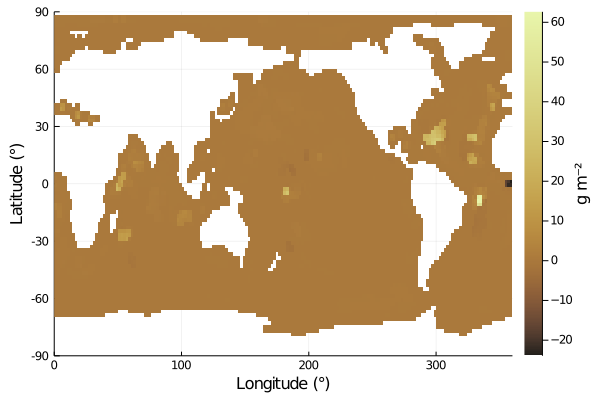

In [16]:
plotverticalintegral(s * u"g/m^3", grd, color=cgrad(:turbid, rev=true, scale=:exp))

compared to the original source

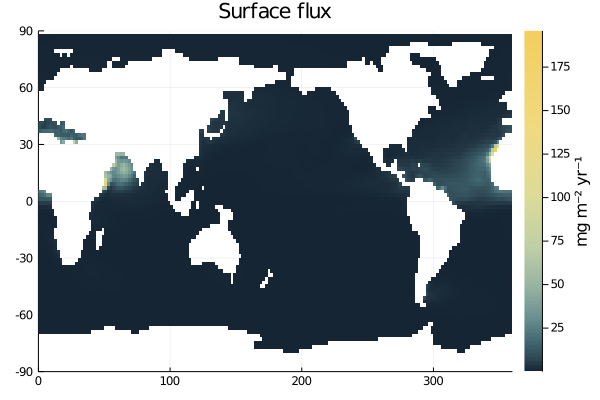

In [17]:
plt1 = plotverticalintegral(s_dust * u"g/m^3/s" .|> u"mg/m^3/yr", xlabel="", ylabel="", grd, color=cgrad(:starrynight, scale=:exp), title="Surface flux")

Huh? This is odd isn't it? What is happening? It seems that dust settles slowly enough to actually explore the ocean basins a little bit.
This is of course dependent on our choice of model parameters.

Let's look at what is exported below 500 m and compare:

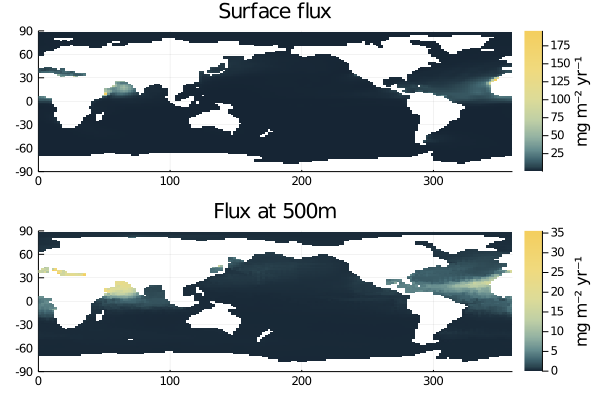

In [18]:
plt2 = plothorizontalslice(s * u"g/m^3" .* w(z,p) * u"m/s" .|> u"mg/yr/m^2", grd, depth=500u"m", color=cgrad(:starrynight, scale=:exp), xlabel="", ylabel="", title="Flux at 500m")
plot(plt1, plt2, layout=(2,1))

We can also take a look at the global mean profile (the horizontal average)

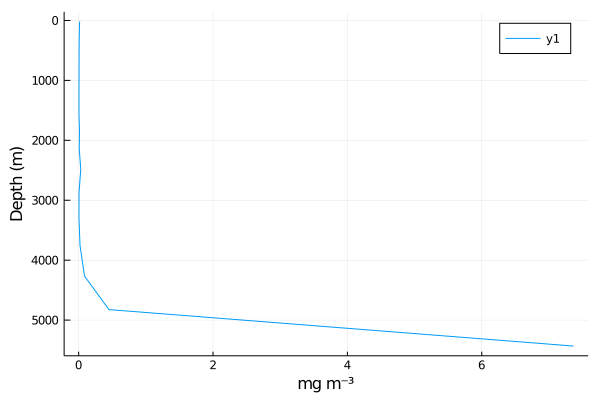

In [19]:
plothorizontalmean(s * u"g/m^3" .|> u"mg/m^3", grd)

As you may see, it also seems that with this model, dust (here with a 1% fraction allowed to stay in the system when it reaches the seafloor)
accumulates a little bit in the deepest boxes of the model grid.

Don't hesitate to play around with the parameters and see how things change!
For example, impose a larger fraction that stays in the bottom or change other parameters via

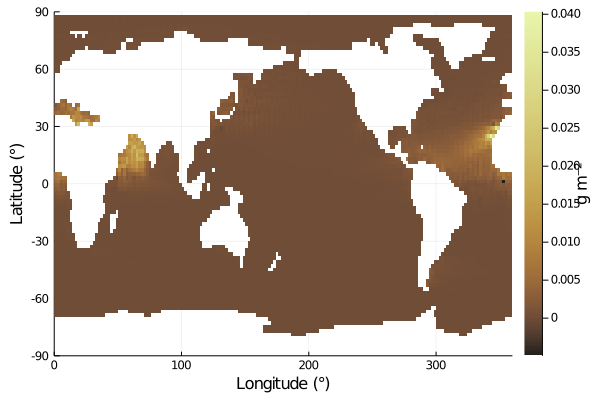

In [20]:
p = DustModelParameters(w₀=0.1u"km/yr", w′=0.1u"km/yr/km", fsedremin=95.0u"percent")
prob = SteadyStateProblem(F, ∇ₓF, x, p)
s = solve(prob, CTKAlg()).u
plotverticalintegral(s * u"g/m^3", grd, color=cgrad(:turbid, rev=true, scale=:exp))

And watch how all the dust accumulates in the deepest holes of the ocean basins!

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*